This is a venue search ranking model 
looking to predict rating according to search session_id_hashed
1. Data input (polars)
2. Data preprocessing
3. Preparing lgb Datasets
4. Model train
5. QA and aggregated evaluation

# Imports

In [1]:
import polars as pl
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
from typing import List
import pandas as pd
from sklearn.metrics import ndcg_score
import os
import pathlib
from typing import Any
import joblib
import numpy as np
import numpy as np
from sklearn.metrics import ndcg_score

# Parameters

In [2]:
label_column = "has_seen_venue_in_this_session"
pred_label = f"pred_{label_column}"
group_column = "session_id_hashed"
rank_column = "popularity"
rank_pos_column = "position_in_list"
predicted_rank_column = f"predicted_{rank_column}"
features = [
    'venue_id',
    'conversions_per_impression',
    'rating',
    'popularity',
    'retention_rate',
    'session_id_hashed',
    'position_in_list',
    'is_from_order_again',
    ]

# Utils

In [3]:
def save_model_to_file(traine_model: Any, model_path: str) -> None:
    joblib.dump(traine_model, model_path)
    
def calculate_ndcg_score(y_true: pl.Series, y_pred:pl.Series):
    return pl.Series([ndcg_score(y_true=y_true, y_score=y_pred)], dtype=pl.Float64)


def my_ndcg(y_true, y_pred):
    y_true = np.asarray([y_true])
    y_pred = np.asarray([y_pred])
    return ndcg_score(y_true=y_true, y_score = y_pred)
def my_relative_percentage_diff(baseline_value, model_value):
    baseline_vector = np.asarray(baseline_value)
    model_vector = np.asarray(model_value)
    print(baseline_vector)
    print(model_vector)
    return abs(baseline_vector-model_vector)/baseline_vector


def convert_boolean_to_int(ranking_data):
    bool_cols = ranking_data.select(pl.col(pl.Boolean)).columns
    ranking_data = ranking_data.with_columns(
        [
            pl.col(column).cast(pl.Int8, strict=False).alias(column)
            for column in bool_cols
            ]
        )
    return ranking_data
def plot_lgb_report(lgb_model, evals_logs: dict, eval_at = [10, 20, 40]):
    for k in eval_at:
        fig, ax = plt.subplots(figsize=(12, 8))
        lgb.plot_metric(evals_logs, ax=ax, metric=f"ndcg@{k}")

        
    lgb.plot_importance(lgb_model, importance_type="gain", figsize=(14, 8))
    lgb.plot_importance(lgb_model, importance_type="split", figsize=(14, 8))
        
def qa_features(model: lgb, features: List[str]):
    feature_importance = {
        feature: importance
        for feature, importance in zip(
        model.feature_name(), model.feature_importance()
        )
    }
    print(feature_importance)
    used_features = [
        f for f in feature_importance
        if feature_importance[f] != 0
    ]
    dropped_features = [f for f in features if f not in used_features]
    print("-------------------------------------------------------")
    print("Used features: ")
    print(used_features)
    print("-------------------------------------------------------")
    print(
        f"passed {len(features)} "
        f"features and model used {len(used_features)} of them"
    )
    print("-------------------------------------------------------")
    print(f"these features were dropped: {dropped_features}")
    return used_features

def generate_predictions(
    test_set: pl.DataFrame, model: lgb, features_to_use: List[str]
) -> pd.DataFrame:
    test_set_pandas = test_set.sort(
        by=[group_column, rank_column], reverse=False
    ).to_pandas()
    test_set_pandas[features_to_use] = test_set_pandas[features_to_use].fillna(0)
    test_x = test_set_pandas[features_to_use]

    test_set_pandas[pred_label] = model.predict(test_x)
    test_set_pandas[predicted_rank_column] = (
        test_set_pandas.groupby(group_column)[pred_label]
        .rank(method="first", ascending=False)
    )
    return test_set_pandas
def add_purchase_indicator_for_session(sessions):
    sessions = sessions.join(sessions.groupby("session_id").agg(
        pl.col('purchased').max().alias('purchased_in_session')
    ).select('session_id','purchased_in_session'), on='session_id').sort('purchased_in_session')
    return sessions
def drop_sessions_with_no_interactions(ranking_data):
    active_sessions = (
        ranking_data
        .filter(pl.col(label_column)==1)
        .select("session_id","position_in_list", "popularity").sort("session_id").groupby("session_id").count().sort("count")\
        .filter(pl.col("count")>1).select("session_id")
    )
    active_ranking_data = ranking_data.join(active_sessions, on="session_id")

    return active_ranking_data

# Read data

In [4]:
%%time
sessions = pl.read_csv("../sessions.csv")
sessions = sessions.drop_nulls()
venues = pl.read_csv("../venues.csv")
venues = venues.drop_nulls()

CPU times: user 303 ms, sys: 426 ms, total: 728 ms
Wall time: 332 ms


# Join venue data with search data

In [5]:
ranking_data = sessions.join(venues, on="venue_id")
ranking_data = convert_boolean_to_int(ranking_data)
# hex_string = "0a21dde9-1495-417c-bb9d-9922b81f2e6a"

ranking_data = ranking_data.with_column(
    pl.col("session_id").str.replace("-","").alias("session_id_hashed").hash(seed=0)
)

/tmp/ipykernel_50326/621109970.py:5: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  ranking_data = ranking_data.with_column(


# Split data into train, val and test

In [6]:
train_set, unseen_set = train_test_split(ranking_data, train_size=0.2, test_size=0.8, random_state=42)
val_set, test_set = train_test_split(unseen_set, train_size=0.2, test_size=0.8, random_state=42)
train_set.shape, val_set.shape, test_set.shape

((232757, 16), (186206, 16), (744825, 16))

# prepare datasets

In [7]:
train_set = train_set.sort(by=[group_column, rank_column], reverse=False)
train_set_group_sizes = (
    train_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

val_set = val_set.sort(by=[group_column, rank_column], reverse=False)
val_set_group_sizes = (
    val_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

In [8]:
%%time

train_y = train_set[[label_column]]
train_x = train_set[features]

val_y = val_set[[label_column]]
val_x = val_set[features]

test_x = test_set[features]

lgb_train_set = lgb.Dataset(
    train_x.to_pandas(),
    label=train_y.to_pandas(),
    group=train_set_group_sizes.to_numpy(),
    free_raw_data=True
).construct()

lgb_valid_set = lgb.Dataset(
    val_x.to_pandas(),
    label=val_y.to_pandas(),
    group=val_set_group_sizes.to_numpy(),
    reference=lgb_train_set,
    free_raw_data=True
).construct()

# some memory management
# del train_set
# del val_set
del train_y
del train_x

import gc

gc.collect()

CPU times: user 335 ms, sys: 54.1 ms, total: 389 ms
Wall time: 219 ms


/workspaces/personalization/.venv/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/workspaces/personalization/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/workspaces/personalization/.venv/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


25

In [9]:

data_path: str = "/tmp/lgb_train_set.binary"
n_rows: int = lgb_train_set.num_data()
n_features: int = lgb_train_set.num_feature()

print(f"Number of rows: {n_rows}")


print(f"Number of columns: {n_features}")
os.system(f"rm -rf {data_path}")
lgb_train_set.save_binary(data_path)
# Define the path to the binary file
 


# Create a Path object from a string
my_path = pathlib.Path(data_path)

# Print the Path object
print(my_path)

# Load the dataset from the binary file
dataset = lgb.Dataset(my_path, free_raw_data=False).construct()

# Print some information about the dataset
print(f"Number of rows: {dataset.num_data()}")
print(f"Number of columns: {dataset.num_feature()}")
assert dataset.num_data() == n_rows
assert dataset.num_feature() == n_features

Number of rows: 232757
Number of columns: 8
[LightGBM] [Info] Saving data to binary file /tmp/lgb_train_set.binary
/tmp/lgb_train_set.binary
[LightGBM] [Info] Load from binary file /tmp/lgb_train_set.binary
Number of rows: 232757
Number of columns: 8


# Train

In [10]:
lgb_params = {
    "objective": "lambdarank",
    "num_leaves": 100,
    "min_sum_hessian_in_leaf": 100,
    "metric": "ndcg",
    "ndcg_eval_at": [10, 20, 40],
    "learning_rate": 0.8,
    "force_row_wise": True,
    "num_iterations": 10,
}


In [11]:
%%time

evals_logs = {}
lgb_params
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train_set,
    valid_sets=[lgb_valid_set, lgb_train_set],
    valid_names=["val", "train"],
    verbose_eval=25,
    evals_result=evals_logs,
    early_stopping_rounds=25
)

[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 232757, number of used features: 8


/workspaces/personalization/.venv/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/workspaces/personalization/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/workspaces/personalization/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/worksp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	train's ndcg@10: 0.999011	train's ndcg@20: 0.999091	train's ndcg@40: 0.999143	val's ndcg@10: 0.99837	val's ndcg@20: 0.998361	val's ndcg@

# QA

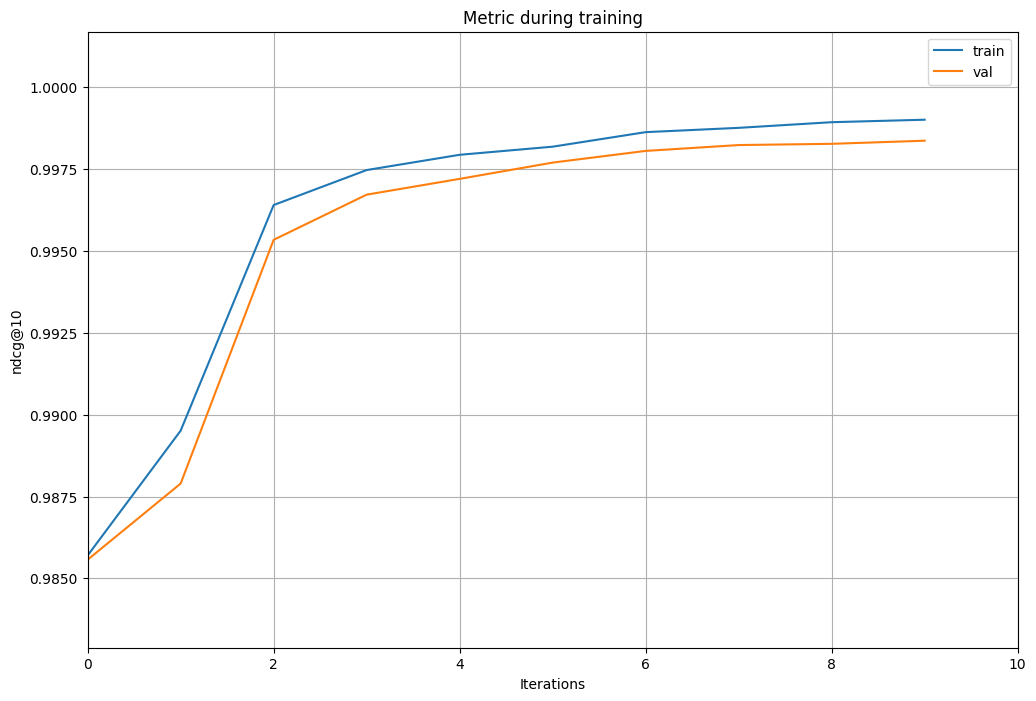

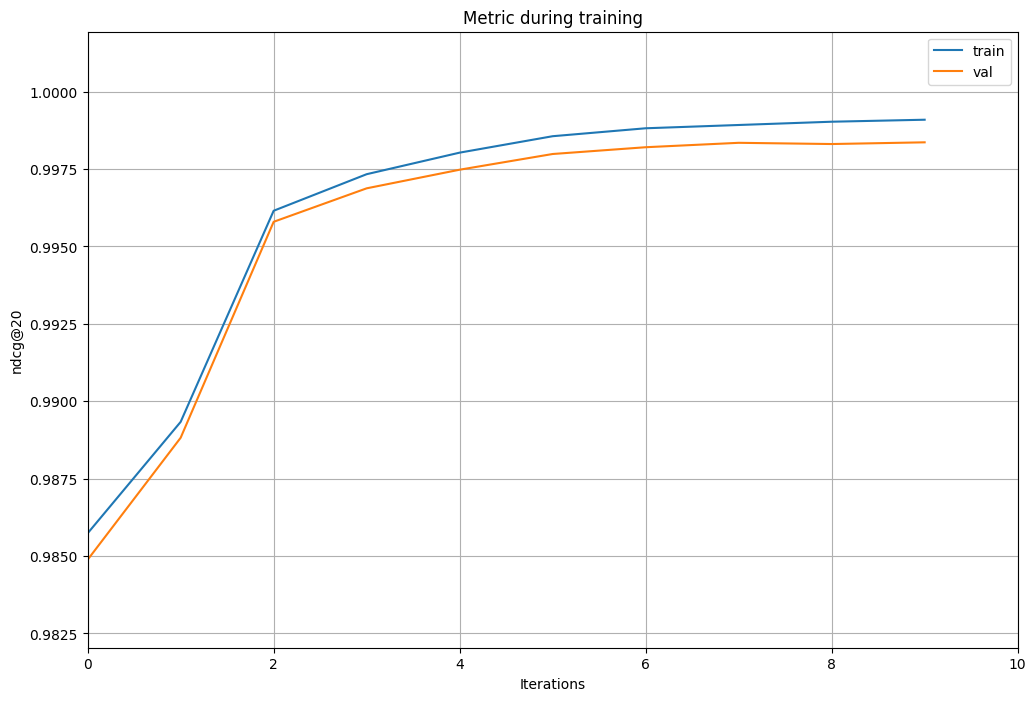

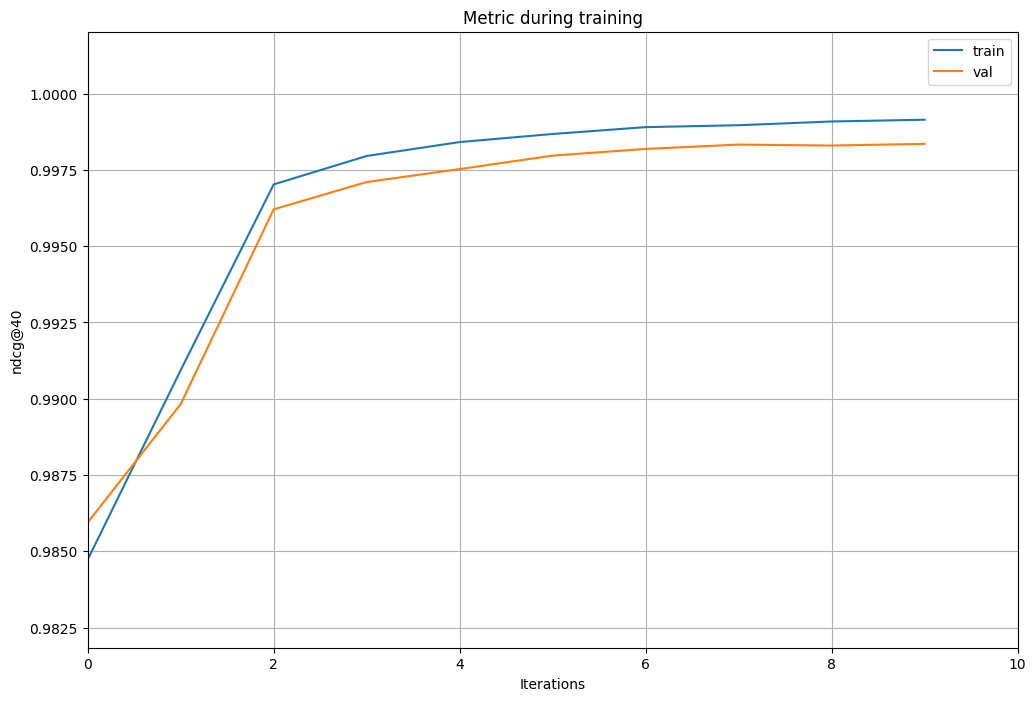

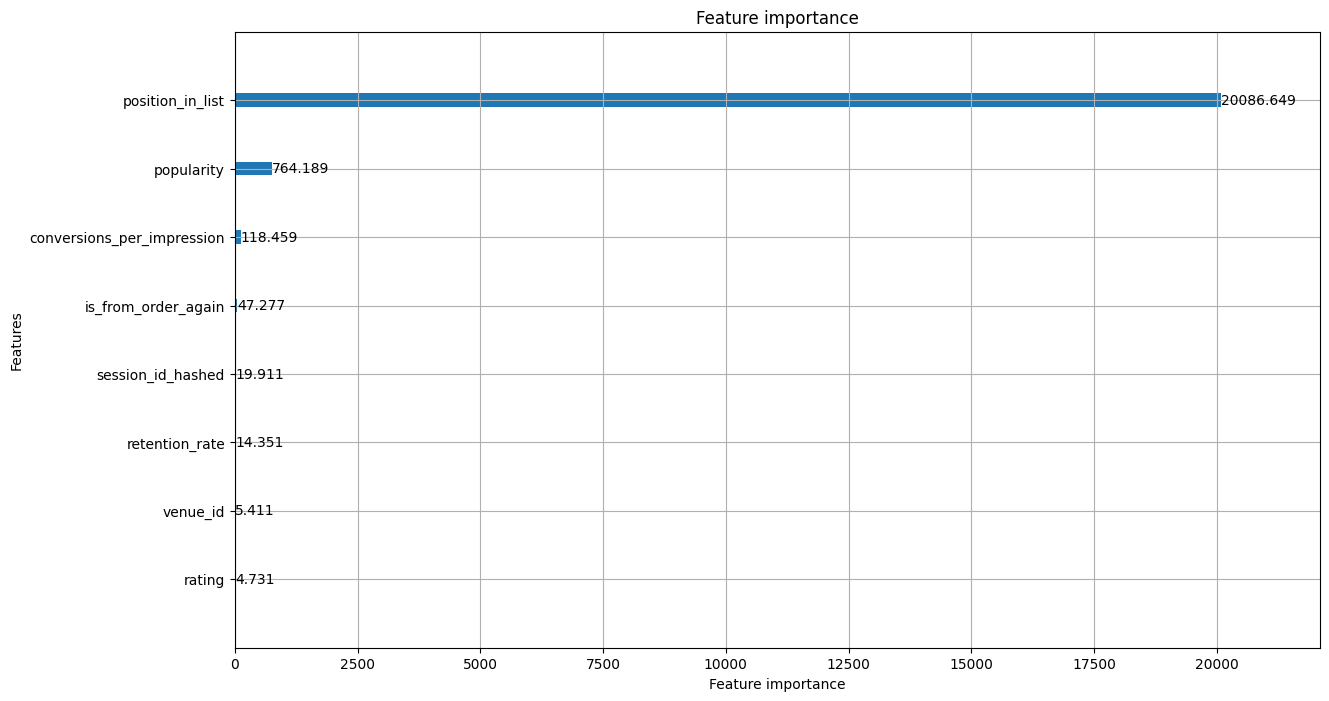

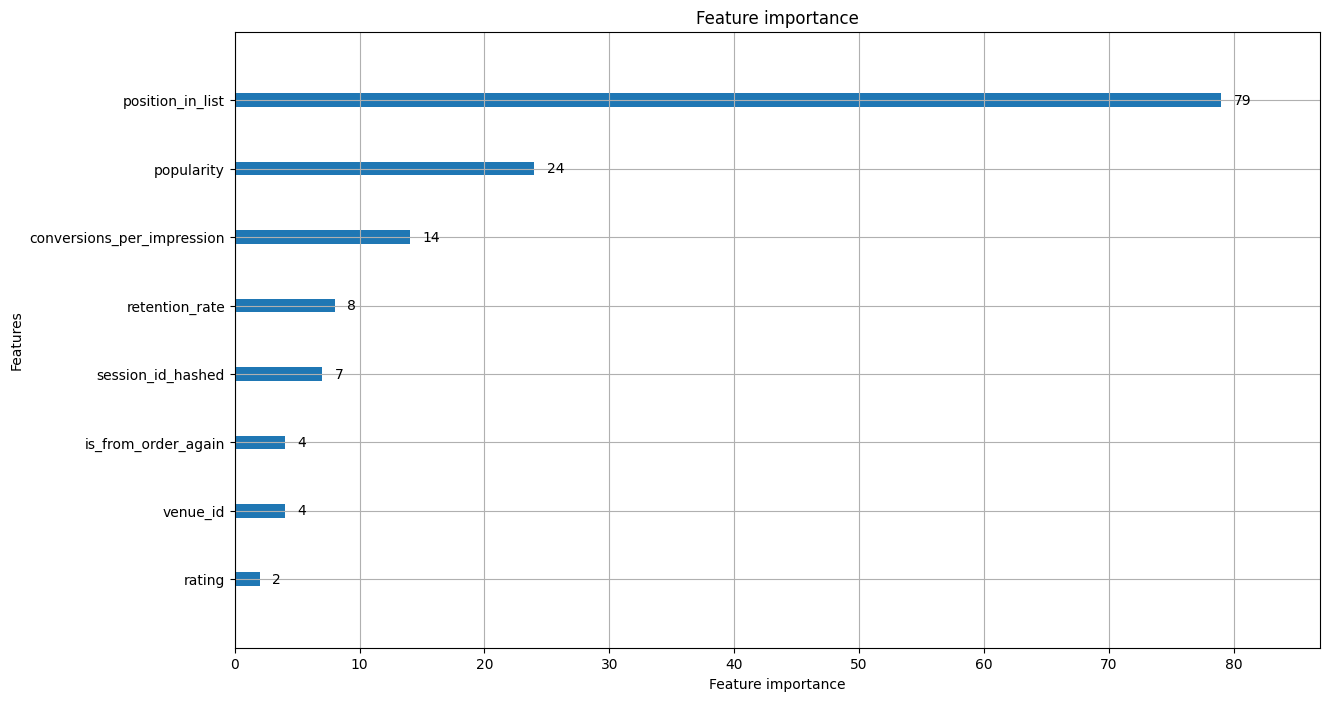

In [12]:
plot_lgb_report(lgb_model, evals_logs)

# Check we do not drop any features

In [13]:
used_features = qa_features(lgb_model, features)
assert used_features == features
used_features


{'venue_id': 4, 'conversions_per_impression': 14, 'rating': 2, 'popularity': 24, 'retention_rate': 8, 'session_id_hashed': 7, 'position_in_list': 79, 'is_from_order_again': 4}
-------------------------------------------------------
Used features: 
['venue_id', 'conversions_per_impression', 'rating', 'popularity', 'retention_rate', 'session_id_hashed', 'position_in_list', 'is_from_order_again']
-------------------------------------------------------
passed 8 features and model used 8 of them
-------------------------------------------------------
these features were dropped: []


['venue_id',
 'conversions_per_impression',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'position_in_list',
 'is_from_order_again']

# save the trained model

In [14]:
%%time

save_model_to_file(lgb_model, "/tmp/venues_ranking.pkl")

CPU times: user 4.24 ms, sys: 63 µs, total: 4.3 ms
Wall time: 2.58 ms


# Offline eval, train data is only 20 perecnt of 1.3 million session data

## generate predictions and rank

In [15]:
predictions = generate_predictions(test_set, lgb_model, features_to_use=features)
predictions_pl = pl.DataFrame(predictions)


In [16]:
active_ranking_data = drop_sessions_with_no_interactions(predictions_pl)

In [17]:
%%time
baseline_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('baseline_ndcg')
    ])
)

CPU times: user 650 ms, sys: 465 µs, total: 651 ms
Wall time: 640 ms


In [18]:
%%time
model_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col(f"predicted_{rank_column}")], lambda s: my_ndcg(s[0],s[1]) ).alias('model_ndcg')
    ])
)

CPU times: user 687 ms, sys: 19.6 ms, total: 707 ms
Wall time: 690 ms


In [19]:
metric_columns = ["baseline_ndcg", "model_ndcg"]

## calculate baseline ndcg and model ndcg per session

In [25]:
metric_dataframe = (
    active_ranking_data
    .join(baseline_ndcg_per_sessions, on="session_id")
    .join(model_ndcg_per_sessions, on="session_id")[ used_features + metric_columns]
    .with_columns(
    [
        (pl.col("model_ndcg")-pl.col("baseline_ndcg")).alias("ndcg_diff")
    ]
).groupby("venue_id").agg(
    pl.all().mean(),
)
)

# calculate percentage increase of ndcg per venue and number of sessions each venue had

In [26]:
metric_dataframe.with_columns(
    (abs(pl.col('baseline_ndcg') - pl.col("model_ndcg"))/pl.col('baseline_ndcg') * 100).alias('perc_increase_in_ndcg')
    
).groupby('venue_id').agg(
    pl.col('perc_increase_in_ndcg').mean(),
).join(active_ranking_data.groupby("venue_id").agg(
    pl.count("session_id").count().alias('n_sessions')
), on="venue_id"
).sort('perc_increase_in_ndcg', reverse=True).filter(pl.col("n_sessions")>10)

venue_id,perc_increase_in_ndcg,n_sessions
i64,f64,u32
-8608196287932575311,35.642343,31
-2397771315306826730,30.004252,69
-4202398962129790175,29.795462,59
-3404627363779251642,27.549156,50
6521448431149536288,26.90412,40
8577326395222187072,26.024646,49
-3244037769194260102,25.749645,123
1632710242368082191,25.701895,57
311760795849230167,25.658916,62


# explore predicted rankings on test data

# percentage of venues where we predict popularity

In [23]:
917/1043 * 100

87.91946308724832

## Let us calculate number of purchases per venue, assuming each session is an impressions

In [38]:
active_ranking_data.groupby('venue_id').agg(
    [
        pl.col(rank_column).quantile(0.8).alias(f"q80_{rank_column}"),
        pl.col(predicted_rank_column).quantile(0.8).alias(f"q80_{predicted_rank_column}")]
).filter(pl.col("q80_predicted_popularity")<100).join(
    predictions_pl.filter(pl.col(pred_label)>0).join(
predictions_pl.groupby("venue_id").agg(
    pl.count("session_id_hashed").count().alias('n_sessions')
),
on='venue_id',
).with_columns(
    (pl.col("conversions_per_impression") * pl.col("n_sessions")).alias("n_purchases")
).select("venue_id", "n_purchases", "n_sessions", "position_in_list").filter(pl.col("n_purchases")>0),
on="venue_id"
).sort("n_purchases", reverse=True).unique(subset=["venue_id"])

venue_id,q80_popularity,q80_predicted_popularity,n_purchases,n_sessions,position_in_list
i64,f64,f64,f64,u32,i64
-335161312256390115,5.347756,88.0,651.015917,1506,18
4845286218969696748,3.39608,95.0,421.851734,1160,1
-2322580878215783374,3.445373,98.0,382.843176,894,12
8749613252343289923,2.282621,95.0,347.375121,1319,22
-7364956451618710562,0.829473,85.0,334.491169,982,11
7248946849485846518,12.186685,23.0,321.422069,449,9
-168347584931888253,1.847607,89.0,293.209983,1385,13
-4497545791517062214,27.543922,24.0,279.155654,510,7
-1970346298375932149,0.966034,71.0,273.567315,1429,7
